In [ ]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 ultralytics tqdm PIL
# pip uninstall opencv-python opencv-python-headless -y
# pip install opencv-python-headless

In [ ]:
# import pandas as pd

# df = pd.read_csv('./csv/landmark_digitalization_2.csv')
# df.head()

In [ ]:
# from PIL import Image

# # iterate through df and convert x1, y1, x2, y2 to new coordinates
# for i, row in df.iterrows():
#     img_name = row['ant']
#     x1, y1, x2, y2 = row['x1_lmk'], row['y1_lmk'], row['x2_lmk'], row['y2_lmk']
#     x1_bar, y1_bar, x2_bar, y2_bar = row['x1_bar'], row['y1_bar'], row['x2_bar'], row['y2_bar']
#     img_path = f'./original/{img_name}'
#     if not os.path.exists(img_path):
#         continue

#     # Open the image
#     img = Image.open(img_path)
#     original_width, original_height = img.size
    
#     # Invwert x coordinates
#     x1_norm = x1/original_width
#     x2_norm = x2/original_width

#     # Invert y coordinates
#     y1_norm = (original_height - y1) / original_height
#     y2_norm = (original_height - y2) / original_height
    
#     # do the same for x1_bar, y1_bar, x2_bar, y2_bar
#     x1_bar_norm = x1_bar/original_width
#     x2_bar_norm = x2_bar/original_width
#     y1_bar_norm = (original_height - y1_bar) / original_height
#     y2_bar_norm = (original_height - y2_bar) / original_height
    
#     # Save the new coordinates
#     df.loc[i, 'x1_lmk'] = x1_norm * 640
#     df.loc[i, 'y1_lmk'] = y1_norm * 640
#     df.loc[i, 'x2_lmk'] = x2_norm  * 640
#     df.loc[i, 'y2_lmk'] = y2_norm  * 640
#     df.loc[i, 'x1_bar'] = x1_bar_norm * 640
#     df.loc[i, 'y1_bar'] = y1_bar_norm * 640
#     df.loc[i, 'x2_bar'] = x2_bar_norm * 640
#     df.loc[i, 'y2_bar'] = y2_bar_norm * 640
    
# df.to_csv('./csv/landmark_digitalization_3.csv', index=False)
# # df.head()

# Thorax Only

In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def visualize_yolo_labels(image_path, label_path):
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size
    draw = ImageDraw.Draw(image)

    # Read YOLO annotations
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Parse each annotation
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height, x1, y1, x2, y2 = map(float, parts[1:])

        # Denormalize YOLO bounding box coordinates
        x_center_abs = x_center * img_width
        y_center_abs = y_center * img_height
        width_abs = width * img_width
        height_abs = height * img_height

        # Calculate top-left and bottom-right corners
        x1_abs = x1 * img_width
        y1_abs = y1 * img_height
        x2_abs = x2 * img_width
        y2_abs = y2 * img_height

        # Draw bounding box
        draw.rectangle(
            [
                (x_center_abs - width_abs / 2, y_center_abs - height_abs / 2),
                (x_center_abs + width_abs / 2, y_center_abs + height_abs / 2)
            ],
            outline="green",
            width=2
        )

        # Draw keypoints (x1, y1) and (x2, y2)
        draw.ellipse(
            [(x1_abs - 5, y1_abs - 5), (x1_abs + 5, y1_abs + 5)],
            fill="red",
            outline="red"
        )
        draw.ellipse(
            [(x2_abs - 5, y2_abs - 5), (x2_abs + 5, y2_abs + 5)],
            fill="red",
            outline="red"
        )

        # Add labels near the keypoints
        draw.text((x1_abs + 5, y1_abs - 15), "P1", fill="red")
        draw.text((x2_abs + 5, y2_abs - 15), "P2", fill="red")

        # Add class label
        draw.text(
            (x_center_abs - width_abs / 2, y_center_abs - height_abs / 2 - 15),
            f"Class {class_id}",
            fill="green"
        )

    # Show the image
    # image.show()
    display(image)



In [ ]:
# image_path = './thorax_and_scale_dataset/images/train/anic32-900190-1_p_1.jpg'
# label_path = './thorax_and_scale_dataset/labels/train/anic32-900190-1_p_1.txt'
# visualize_yolo_labels(image_path, label_path)

In [ ]:
import os
import random

directory_path = './original' #'../resized_images'  # Replace with your directory path

def choose_random_file(directory, to_skip=set([])):
    # Get a list of all files in the directory
    files = os.listdir(directory)
    
    # Filter out directories (if you want only files)
    files = [f for f in files if os.path.isfile(os.path.join(directory, f))]
    
    # Check if the directory is empty
    if not files:
        print("The directory is empty.")
        return None
    
    # Choose a random file
    random_file = random.choice(files)
    if(random_file in to_skip):
        choose_random_file(directory)
    
    return random_file

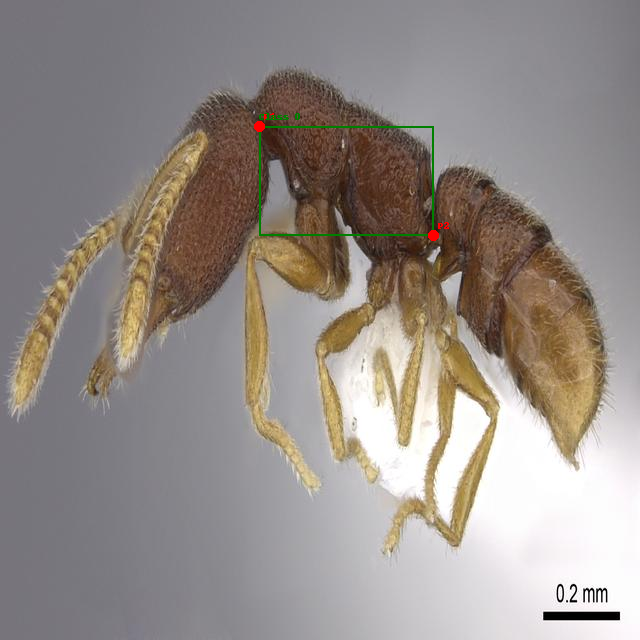

In [ ]:
file = choose_random_file("./thorax_dataset/images/train")
image_path = f'./thorax_dataset/images/train/{file}'
label_path = f'./thorax_dataset/labels/train/{file.replace(".jpg", ".txt")}'
visualize_yolo_labels(image_path, label_path)

In [5]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0)) 

PyTorch version: 2.2.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: Tesla V100-SXM2-32GB


In [ ]:
from ultralytics import YOLO

# Load the model
model = YOLO("yolo11s-pose.pt")  # Use the pretrained model

# Train the model
model.train(
    data="./thorax_dataset/dataset.yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    verbose=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/abdelrah/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
engine/trainer: task=pose, mode=train, model=yolo11s-pose.pt, data=./dataset_original.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf

100%|██████████| 755k/755k [00:00<00:00, 9.28MB/s]

Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[2, 2]
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512,

train: Scanning /mnt/lts4/scratch/home/abdelrah/ml_project_2/dataset/labels/train.cache... 1474 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1474/1474 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'



val: Scanning /mnt/lts4/scratch/home/abdelrah/ml_project_2/dataset/labels/val.cache... 371 images, 0 backgrounds, 0 corrupt: 100%|██████████| 371/371 [00:00<?, ?it/s]


Plotting labels to runs/pose/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/pose/train12
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.38G      2.122      1.437          0      2.149      1.641          8        640: 100%|██████████| 93/93 [00:15<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]

                   all        371        371      0.568      0.474      0.481      0.208      0.687      0.622      0.695       0.53



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.46G       1.75     0.5612          0      1.341      1.309          5        640: 100%|██████████| 93/93 [00:11<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        371        371      0.594      0.558      0.588      0.284      0.654      0.677      0.746      0.685



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.46G      1.742     0.4939          0      1.399      1.366          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]

                   all        371        371      0.806      0.681      0.748      0.357      0.854      0.776      0.887      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.46G      1.647     0.4064          0      1.298      1.293          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        371        371      0.827      0.639      0.719      0.349      0.836      0.755      0.856      0.804



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.42G      1.592     0.3678          0      1.239      1.261          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]

                   all        371        371      0.886      0.755      0.834      0.476      0.928      0.852      0.934      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.46G      1.562     0.3529          0      1.177      1.269          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.36it/s]

                   all        371        371      0.877      0.749      0.805      0.453      0.938      0.873      0.946      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.46G      1.566     0.3665          0       1.21      1.257          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]

                   all        371        371      0.837      0.722      0.801      0.454      0.905      0.809      0.914      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.46G      1.482     0.2568          0      1.119      1.231          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]

                   all        371        371      0.864      0.773      0.823      0.455      0.897      0.903      0.946      0.908



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.43G      1.551     0.2932          0      1.122      1.265          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]

                   all        371        371      0.839      0.689      0.803      0.466      0.829       0.79      0.897      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.46G       1.47     0.3156          0      1.106      1.228          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        371        371      0.862      0.775      0.846      0.514      0.903      0.828      0.933      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.46G      1.454     0.2716          0      1.048      1.231          3        640: 100%|██████████| 93/93 [00:11<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        371        371      0.864      0.819      0.874      0.542      0.895      0.874      0.945      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.46G       1.41     0.2824          0      1.046      1.203          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        371        371      0.844      0.798      0.856      0.482      0.904      0.879      0.949      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.42G       1.44     0.2518          0      1.051      1.201          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]

                   all        371        371      0.906      0.717      0.853      0.529      0.883      0.784      0.918       0.91



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.46G      1.396     0.2224          0      1.025      1.209          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]

                   all        371        371      0.903      0.817      0.876      0.542      0.961      0.887      0.958      0.942



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.46G      1.374     0.2057          0     0.9982        1.2          8        640: 100%|██████████| 93/93 [00:12<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]

                   all        371        371      0.892      0.811      0.869      0.516      0.944       0.91      0.968      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.46G      1.339     0.1947          0     0.9693      1.178          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        371        371      0.921      0.813      0.891      0.519      0.979      0.879      0.969      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.42G      1.367     0.2045          0     0.9553      1.186          5        640: 100%|██████████| 93/93 [00:11<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        371        371      0.903      0.819      0.893      0.542      0.972        0.9      0.973      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.46G      1.339     0.1982          0     0.9494       1.17          3        640: 100%|██████████| 93/93 [00:11<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        371        371      0.909      0.806       0.89       0.56      0.949      0.879      0.964      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.46G      1.309     0.1891          0     0.9364      1.171          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        371        371      0.912      0.803      0.889      0.554      0.947      0.871      0.964      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.46G      1.317     0.1667          0     0.9323      1.168          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        371        371      0.949      0.809      0.905      0.569      0.947      0.909      0.971      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.42G      1.323     0.1625          0     0.9348      1.164          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]

                   all        371        371      0.897      0.849      0.902      0.565      0.946      0.902      0.969      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.47G       1.27      0.185          0      0.925      1.146          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

                   all        371        371      0.881       0.82      0.883      0.522      0.954      0.886      0.976      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.46G      1.306     0.2013          0     0.9284       1.17          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

                   all        371        371      0.928      0.787      0.891      0.544      0.927      0.871      0.957      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.46G      1.313     0.1947          0     0.9218      1.152          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.60it/s]

                   all        371        371      0.922      0.852      0.911      0.543      0.966      0.922      0.979      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.42G       1.26     0.1629          0     0.8727      1.126          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]

                   all        371        371      0.943      0.833      0.909      0.565      0.956      0.898      0.971      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.47G      1.251      0.151          0     0.8683      1.135          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.64it/s]

                   all        371        371      0.922      0.814      0.897      0.562      0.963        0.9      0.976      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.46G      1.237     0.1436          0     0.8698      1.138          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]

                   all        371        371      0.927      0.841      0.898      0.546       0.96      0.904      0.969      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.46G      1.257     0.1774          0     0.8838      1.144          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]

                   all        371        371      0.918       0.82      0.905      0.564      0.963      0.889      0.967      0.953



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.42G      1.219      0.153          0     0.8623      1.125          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]

                   all        371        371      0.911      0.822      0.897      0.567      0.951      0.943      0.978      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.47G      1.211      0.137          0     0.8385      1.134          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.71it/s]

                   all        371        371      0.909      0.825      0.889      0.555      0.966      0.915      0.978       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.46G      1.211      0.126          0     0.8273      1.132          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.67it/s]

                   all        371        371      0.941      0.853      0.918      0.568       0.98      0.924      0.983      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.46G      1.211     0.1425          0     0.8373      1.128          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        371        371       0.94      0.846      0.925      0.576      0.948      0.935      0.983      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.42G      1.191     0.1355          0     0.8237      1.118          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        371        371      0.923      0.873      0.924      0.598      0.971      0.925      0.984      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.47G      1.189     0.1409          0     0.8149      1.112          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.60it/s]

                   all        371        371      0.946      0.849      0.923      0.561      0.958      0.922       0.98      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.46G       1.16      0.121          0     0.8067      1.099          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]

                   all        371        371      0.915      0.825      0.907      0.564      0.946      0.914      0.977      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.46G      1.172     0.1176          0     0.8014      1.113          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]

                   all        371        371      0.955      0.859      0.926        0.6      0.956      0.927      0.979      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.42G      1.153     0.1329          0     0.7968      1.111          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]

                   all        371        371      0.918      0.841      0.914      0.595      0.952      0.907      0.972      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.47G       1.17     0.1367          0     0.8053      1.113          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]

                   all        371        371      0.936      0.852      0.913      0.562       0.96      0.941      0.986       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.46G      1.144     0.1034          0     0.7885      1.094          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]

                   all        371        371      0.947      0.846      0.921      0.591      0.971      0.915      0.984      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.46G      1.122     0.1069          0     0.7816      1.088          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        371        371      0.917      0.846      0.914      0.587      0.946      0.927      0.982      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.42G      1.118     0.1067          0     0.7602      1.082          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all        371        371      0.935      0.871      0.918      0.603      0.977      0.911      0.982      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.47G      1.095      0.122          0     0.7802      1.082          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]

                   all        371        371      0.943      0.868       0.93      0.591      0.971      0.933      0.988      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.46G      1.112     0.1227          0     0.7589      1.082          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.64it/s]

                   all        371        371      0.936      0.868      0.926      0.592      0.966      0.941      0.986      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.46G       1.12     0.1199          0     0.7678      1.086          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]

                   all        371        371      0.934      0.846      0.925      0.614      0.961      0.937      0.985      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.42G      1.113     0.1197          0     0.7889      1.088          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]

                   all        371        371      0.938      0.868      0.931      0.602      0.978      0.906      0.978      0.972



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.47G      1.093    0.09687          0     0.7466      1.081          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]

                   all        371        371      0.912      0.868      0.918       0.58      0.955      0.941      0.983      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.47G      1.054    0.09787          0     0.7312      1.069          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.935      0.879      0.932      0.614      0.969      0.935      0.987      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.46G       1.08     0.1016          0      0.722      1.066          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all        371        371      0.958       0.87      0.931      0.611      0.981       0.93      0.985      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.42G      1.045    0.09641          0     0.7202      1.052          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.928      0.876      0.926      0.598      0.969      0.933      0.983      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.47G      1.059     0.1081          0     0.7181      1.056          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        371        371      0.939      0.863      0.923        0.6      0.969      0.939      0.987      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.46G      1.042    0.09265          0      0.729      1.051          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.70it/s]

                   all        371        371      0.927      0.881      0.924      0.613      0.954      0.951      0.984      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.46G       1.04    0.09556          0     0.7021      1.052          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all        371        371       0.93      0.887      0.935      0.601      0.967      0.944      0.987      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.42G      1.028    0.08944          0     0.7071      1.047          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]

                   all        371        371      0.932      0.887      0.927      0.593      0.973      0.954       0.99      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.47G      1.018    0.09068          0     0.6928      1.037          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

                   all        371        371      0.927      0.888      0.935      0.616      0.977      0.951      0.988      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.46G      1.015    0.09034          0     0.6903      1.051          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

                   all        371        371      0.926      0.887      0.939      0.619      0.972      0.938      0.988      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.46G       1.02    0.09853          0     0.6914      1.047          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]

                   all        371        371      0.923      0.874      0.928      0.594      0.967      0.956      0.989      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.42G      1.008    0.09576          0     0.6948      1.038          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.67it/s]

                   all        371        371      0.931      0.879      0.932      0.623      0.972      0.951      0.987      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.47G     0.9946    0.08813          0     0.6655      1.039          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.927      0.886       0.93      0.604      0.973      0.949       0.99      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.46G      0.979     0.0773          0     0.6585      1.022          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]

                   all        371        371      0.937      0.882      0.932      0.621      0.954      0.935      0.985      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.46G     0.9829    0.09171          0     0.6784       1.04          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.60it/s]

                   all        371        371      0.962      0.849      0.928      0.614      0.982       0.93      0.988      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.42G      1.014    0.08449          0     0.6841      1.033          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]

                   all        371        371      0.933      0.873      0.928      0.604      0.968      0.962      0.991      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.47G     0.9826    0.08041          0      0.677      1.034          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.935      0.873      0.931      0.608      0.962      0.962       0.99      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.46G     0.9534    0.07504          0     0.6672      1.028          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.64it/s]

                   all        371        371      0.936       0.87      0.931      0.601      0.988      0.941      0.991       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.46G     0.9701    0.08931          0     0.6682       1.03          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        371        371      0.942      0.879      0.936      0.601       0.97       0.96      0.992      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.42G     0.9502    0.07101          0     0.6467      1.004          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]

                   all        371        371      0.942      0.884      0.935      0.623      0.967       0.97      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.47G     0.9365    0.06942          0     0.6475      1.017          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]

                   all        371        371      0.932      0.893       0.94      0.607       0.97      0.965      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.46G     0.9494    0.06988          0     0.6388      1.026          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.948      0.868      0.932      0.609      0.969      0.978      0.992       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.46G      0.921    0.06836          0     0.6231      1.006          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.77it/s]

                   all        371        371      0.923      0.876      0.935      0.619      0.965      0.963      0.991      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.42G     0.9169    0.06048          0     0.6279       1.01          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.901      0.892      0.926      0.614      0.962      0.954      0.989      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.47G     0.9225    0.05573          0     0.6276      1.005          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.922      0.891      0.936      0.632       0.97       0.96       0.99      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.47G     0.9244    0.06877          0     0.6319      1.006          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        371        371      0.934      0.874      0.933      0.617      0.967      0.957      0.991      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.46G     0.8913    0.07384          0     0.6297      1.002          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]

                   all        371        371       0.94      0.886      0.934      0.609      0.991      0.937      0.991      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.42G     0.8935    0.06339          0      0.605          1          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]

                   all        371        371      0.925      0.881      0.934      0.626       0.97      0.962      0.992      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.47G     0.8904    0.06863          0     0.6032     0.9919          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.928      0.876      0.929       0.63      0.962      0.965      0.991       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.46G     0.8827    0.07532          0     0.6033     0.9938          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.936      0.876      0.931      0.616      0.949      0.976      0.992      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.46G     0.8942    0.06367          0     0.5978      1.005          1        640: 100%|██████████| 93/93 [00:12<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.949      0.871      0.934       0.64      0.952      0.964      0.991      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.42G     0.8962    0.06761          0     0.6137     0.9942          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.924      0.889      0.934      0.622       0.96      0.979      0.992      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.47G     0.8611    0.06767          0      0.591     0.9875          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.75it/s]

                   all        371        371      0.939      0.871      0.933      0.627      0.973      0.951      0.989      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.46G     0.8638    0.05997          0     0.5991     0.9917          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all        371        371      0.951      0.854      0.929      0.617      0.962      0.976      0.991      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.46G     0.8488    0.05894          0      0.589     0.9864          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.915      0.899      0.931      0.621      0.977      0.968      0.991      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.42G     0.8435    0.05959          0     0.5813     0.9783          6        640: 100%|██████████| 93/93 [00:12<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        371        371      0.917        0.9      0.936      0.627      0.967      0.962      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.47G     0.8375    0.05703          0     0.5846     0.9786          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]

                   all        371        371      0.937       0.86      0.931      0.621       0.97      0.962      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.46G     0.8343    0.05088          0      0.579     0.9825          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]

                   all        371        371      0.949       0.86       0.93      0.624      0.973       0.96      0.991       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.46G     0.8225    0.06598          0     0.5708     0.9718          3        640: 100%|██████████| 93/93 [00:12<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all        371        371      0.939      0.865      0.931      0.621      0.981      0.959      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.42G     0.8231    0.05772          0     0.5673     0.9813          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.71it/s]

                   all        371        371       0.95      0.868      0.936      0.629      0.985      0.951      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.47G     0.8557    0.06124          0     0.5904     0.9959          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        371        371      0.925      0.894      0.938      0.634      0.973       0.97      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.46G     0.8148    0.05738          0     0.5819     0.9759          3        640: 100%|██████████| 93/93 [00:11<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]

                   all        371        371      0.969      0.856      0.936      0.633      0.978      0.973      0.993      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.46G     0.8172    0.05518          0     0.5759     0.9719          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all        371        371      0.915      0.895      0.938      0.637      0.973      0.962      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.42G     0.8015     0.0522          0      0.561     0.9708          4        640: 100%|██████████| 93/93 [00:12<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]

                   all        371        371      0.923      0.889       0.94      0.623      0.977      0.962      0.992      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.46G     0.7977    0.04998          0     0.5621     0.9733          5        640: 100%|██████████| 93/93 [00:12<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]

                   all        371        371      0.918      0.889      0.938      0.625      0.975      0.959      0.992      0.982


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.46G     0.6453    0.03253          0     0.3814     0.8931          2        640: 100%|██████████| 93/93 [00:13<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]

                   all        371        371       0.93      0.887      0.934       0.62       0.96      0.976      0.992       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.46G     0.6457    0.03414          0     0.3709      0.888          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        371        371      0.928      0.892       0.94      0.633       0.97      0.965      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.42G     0.6397    0.02515          0     0.3666     0.8832          2        640: 100%|██████████| 93/93 [00:11<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all        371        371      0.952      0.856      0.931      0.632      0.981      0.968      0.993      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.46G     0.6394    0.03008          0     0.3654     0.8866          2        640: 100%|██████████| 93/93 [00:11<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]

                   all        371        371      0.927      0.881       0.93      0.619      0.968      0.979      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.46G     0.6307    0.02345          0     0.3571      0.883          2        640: 100%|██████████| 93/93 [00:11<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        371        371      0.925      0.889      0.936       0.63      0.971      0.973      0.993      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.46G     0.6049    0.02224          0     0.3481     0.8777          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.83it/s]

                   all        371        371      0.924      0.888      0.933      0.631      0.986      0.961      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.42G     0.5922    0.02353          0     0.3443     0.8774          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all        371        371      0.929      0.895      0.938      0.631      0.981       0.96      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.47G     0.6018    0.02365          0     0.3491     0.8825          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        371        371      0.928      0.887      0.933      0.631      0.983      0.958      0.992      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.46G     0.5804    0.02486          0     0.3395     0.8712          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.77it/s]

                   all        371        371      0.919       0.89       0.93      0.632      0.975      0.973      0.992      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.46G     0.5935    0.02476          0     0.3426     0.8746          2        640: 100%|██████████| 93/93 [00:12<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        371        371      0.925      0.895      0.934      0.634      0.978      0.975      0.992      0.982



100 epochs completed in 0.422 hours.
Optimizer stripped from runs/pose/train12/weights/last.pt, 19.8MB
Optimizer stripped from runs/pose/train12/weights/best.pt, 19.8MB

Validating runs/pose/train12/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11s-pose summary (fused): 257 layers, 9,699,471 parameters, 0 gradients, 22.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


                   all        371        371      0.949      0.871      0.934       0.64      0.952      0.964      0.991      0.981
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/pose/train12


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9f2dd69d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

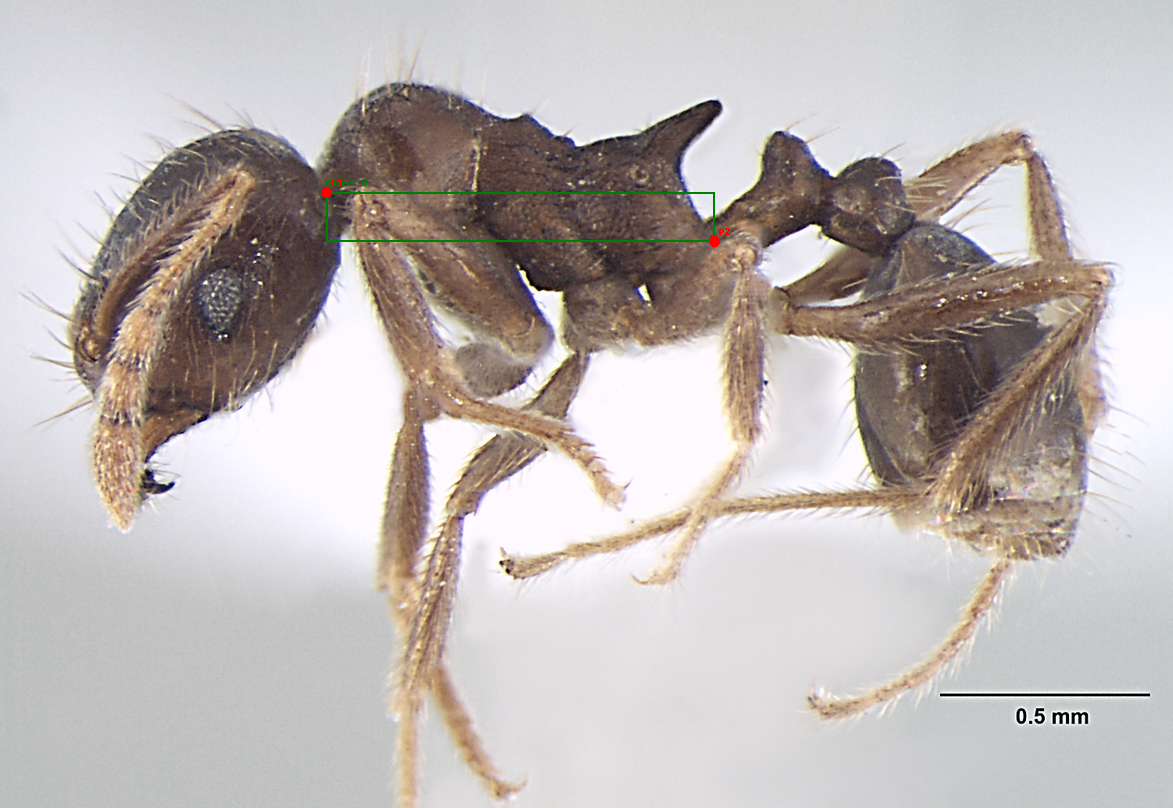

In [6]:
visualize_yolo_labels('./original/antweb1008008_p_1.jpg', './archive/val/antweb1008008_p_1.txt')


image 1/1 /mnt/lts4/scratch/home/abdelrah/ml_project_2/original/antweb1008008_p_1.jpg: 448x640 1 thorax_3, 15.6ms
Speed: 3.5ms preprocess, 15.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


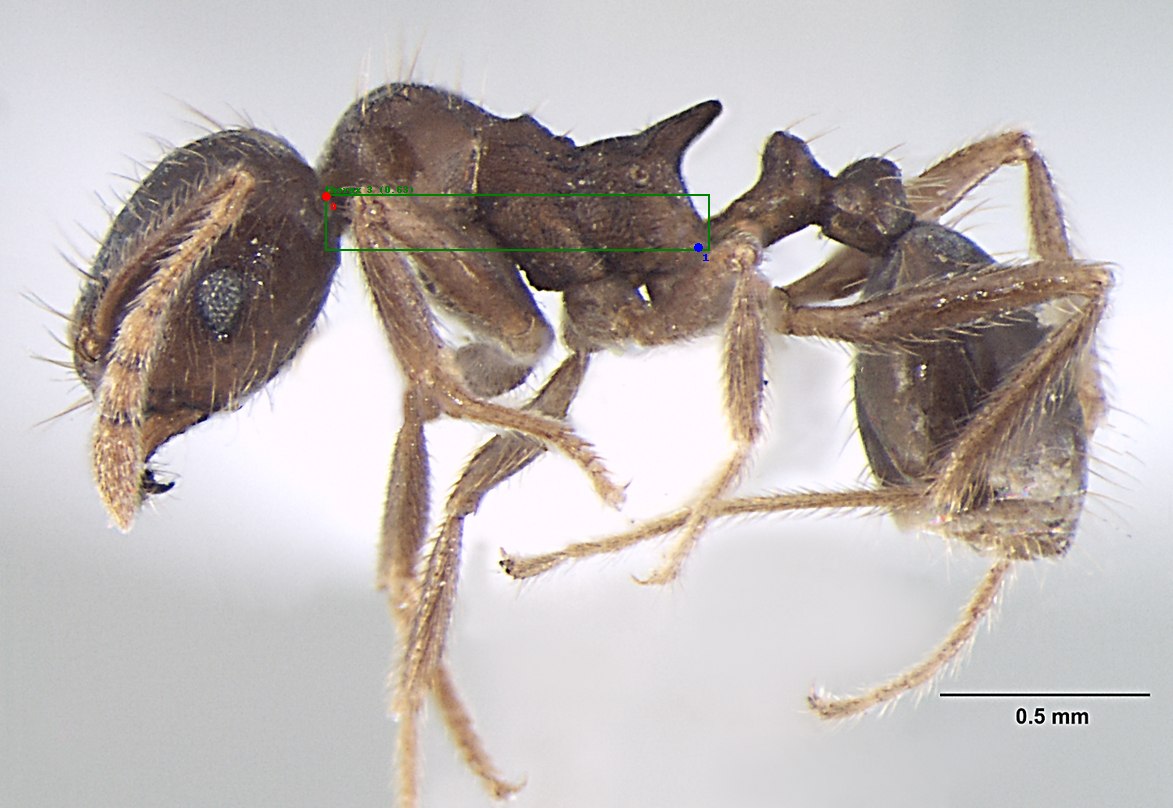

In [ ]:
from PIL import Image, ImageDraw
from IPython.display import display

def visualize_predictions(image_path, results):
    # Load the image using PIL
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Get the first result
    # result = results[0]
    
    # Draw bounding boxes
    boxes = results[0].boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence and class information
        confidence = box.conf[0]
        class_id = box.cls[0]
        class_name = results[0].names[int(class_id)]
        
        # Draw rectangle
        draw.rectangle([(x1, y1), (x2, y2)], outline="green", width=2)
        
        # Add label
        label = f"{class_name} ({confidence:.2f})"
        draw.text((x1, y1 - 10), label, fill="green")
    
    # Draw keypoints if they exist
    if hasattr(results[0], 'keypoints'):
        keypoints = results[0].keypoints
        colors = ["red", "blue", "green", "yellow", "purple"]  # PIL color names
        
        # Convert keypoints to numpy if needed
        if hasattr(keypoints, 'data'):
            kpts = keypoints.data.cpu().numpy()
        else:
            kpts = keypoints.cpu().numpy()
        
        # Draw each keypoint
        for det_idx, det_kpts in enumerate(kpts):
            for idx, kpt in enumerate(det_kpts):
                x, y = int(kpt[0]), int(kpt[1])
                confidence = float(kpt[2]) if kpt.shape[0] > 2 else 1.0
                
                if confidence > 0.5:
                    color = colors[idx % len(colors)]
                    # Draw circle for keypoint
                    draw.ellipse(
                        [(x-4, y-4), (x+4, y+4)],
                        fill=color,
                        outline=color
                    )
                    # Add keypoint index
                    draw.text((x+5, y+5), str(idx), fill=color)
            
            # Draw connections between keypoints if defined
            if hasattr(results[0], 'keypoint_links'):
                for link in results[0].keypoint_links:
                    pt1 = tuple(map(int, det_kpts[link[0]][:2]))
                    pt2 = tuple(map(int, det_kpts[link[1]][:2]))
                    draw.line([pt1, pt2], fill="white", width=1)
    
    # Display the image
    display(image)

# Example usage:
image_path = './original/antweb1008008_p_1.jpg'
results = model.predict(source=image_path)
visualize_predictions(image_path, results)

# Thorax and Bar

In [1]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def visualize_yolo_labels(image_path, label_path):
    # Load the image
    image = Image.open(image_path)
    img_width, img_height = image.size
    draw = ImageDraw.Draw(image)

    # Read YOLO annotations
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Class names mapping
    class_names = {0: "Thorax", 1: "Bar"}

    # Parse each annotation
    for line in lines:
        parts = line.strip().split()
        # print(parts)
        class_id = int(parts[0])
        x_center, y_center, width, height, x1, y1, x2, y2,_,_,_,_ = map(float, parts[1:])

        # Denormalize YOLO bounding box coordinates
        x_center_abs = x_center * img_width
        y_center_abs = y_center * img_height
        width_abs = width * img_width
        height_abs = height * img_height

        # Calculate top-left and bottom-right corners
        x1_abs = x1 * img_width
        y1_abs = y1 * img_height
        x2_abs = x2 * img_width
        y2_abs = y2 * img_height

        # Draw bounding box
        bbox_color = "green" if class_id == 0 else "blue"
        draw.rectangle(
            [
                (x_center_abs - width_abs / 2, y_center_abs - height_abs / 2),
                (x_center_abs + width_abs / 2, y_center_abs + height_abs / 2)
            ],
            outline=bbox_color,
            width=2
        )

        # Draw keypoints (x1, y1) and (x2, y2)
        keypoint_color = "red" if class_id == 0 else "yellow"
        draw.ellipse(
            [(x1_abs - 5, y1_abs - 5), (x1_abs + 5, y1_abs + 5)],
            fill=keypoint_color,
            outline=keypoint_color
        )
        draw.ellipse(
            [(x2_abs - 5, y2_abs - 5), (x2_abs + 5, y2_abs + 5)],
            fill=keypoint_color,
            outline=keypoint_color
        )

        # Add labels near the keypoints
        draw.text((x1_abs + 5, y1_abs - 15), "P1", fill=keypoint_color)
        draw.text((x2_abs + 5, y2_abs - 15), "P2", fill=keypoint_color)

        # Add class label
        draw.text(
            (x_center_abs - width_abs / 2, y_center_abs - height_abs / 2 - 15),
            f"{class_names.get(class_id, 'Unknown')}",
            fill=bbox_color
        )

    # Show the image
    display(image)


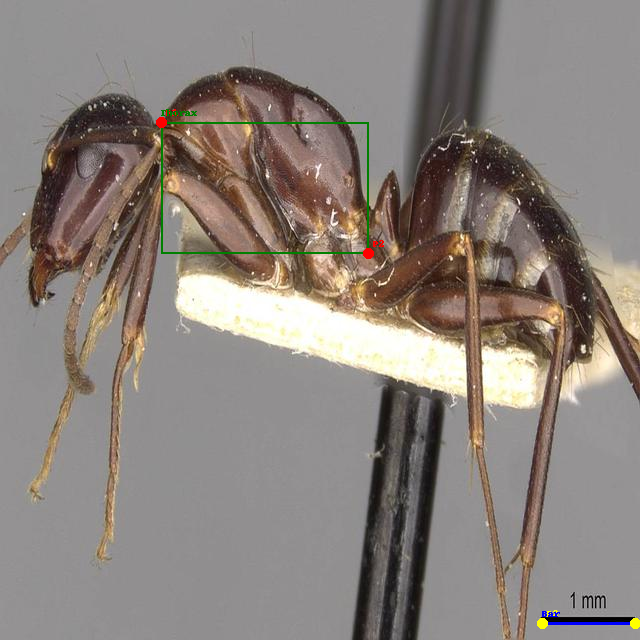

In [24]:
image_path =  './thorax_and_scale_dataset/images/train/casent0910427_p_1.jpg'
label_path =  './thorax_and_scale_dataset/labels/train/casent0910427_p_1.txt'
visualize_yolo_labels(image_path, label_path)

In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0)) 

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU: Tesla V100-SXM2-32GB


In [26]:
from ultralytics import YOLO

# Load the model
model = YOLO("yolo11n.pt")  # Use the pretrained model

# Train the model
model.train(
    data="./thorax_and_scale_dataset/dataset.yaml",
    epochs=50,
    batch=16,
    imgsz=640,
    verbose=True
)

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=./thorax_and_scale_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /mnt/lts4/scratch/home/abdelrah/ml_project_2/thorax_and_scale_dataset/labels/train.cache... 114 images, 0 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
val: Scanning /mnt/lts4/scratch/home/abdelrah/ml_project_2/thorax_and_scale_dataset/labels/val.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.53G      3.176      6.076      2.823          2        640: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         38         76    0.00172       0.25     0.0109    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.51G      2.206      4.349      1.919          4        640: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


                   all         38         76    0.00404        0.5      0.197     0.0731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.51G      2.016      3.568      1.536          6        640: 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]

                   all         38         76    0.00401      0.487      0.188     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.53G      1.925      3.378      1.436          5        640: 100%|██████████| 8/8 [00:00<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]

                   all         38         76    0.00402      0.487      0.312       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.53G       1.91      2.987      1.417          5        640: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         38         76      0.939      0.191      0.385      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.53G      1.925      2.926      1.497          2        640: 100%|██████████| 8/8 [00:00<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


                   all         38         76     0.0038      0.487      0.262      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.54G      1.906      2.868      1.433          7        640: 100%|██████████| 8/8 [00:00<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         38         76    0.00422        0.5      0.066     0.0261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.51G      1.891      2.951      1.516          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         38         76       0.78      0.084      0.175     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.54G      1.832      2.656      1.413          7        640: 100%|██████████| 8/8 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         38         76       0.94      0.342      0.391      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.52G      1.724      2.704      1.344          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]

                   all         38         76      0.961      0.311      0.398      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.52G      1.807      2.498      1.375          6        640: 100%|██████████| 8/8 [00:00<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         38         76      0.933      0.424      0.456      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.52G      1.727      2.329      1.367          3        640: 100%|██████████| 8/8 [00:00<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]

                   all         38         76      0.927      0.289       0.35      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.52G      1.767      2.472      1.359          3        640: 100%|██████████| 8/8 [00:00<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         38         76      0.922      0.354      0.408        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.52G      1.688      2.292      1.354          6        640: 100%|██████████| 8/8 [00:00<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         38         76       0.79      0.263      0.288      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.52G      1.748      2.301      1.383         10        640: 100%|██████████| 8/8 [00:00<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


                   all         38         76      0.675      0.197      0.153     0.0577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.52G      1.639      2.149      1.329          4        640: 100%|██████████| 8/8 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         38         76      0.737      0.225      0.212     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.52G      1.729       2.19      1.343          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all         38         76      0.751      0.263      0.308      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.52G      1.754      2.155      1.378          8        640: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         38         76      0.961      0.342      0.433      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.52G      1.686      2.135      1.323          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


                   all         38         76      0.955        0.4      0.471       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.52G      1.696      2.035      1.326          6        640: 100%|██████████| 8/8 [00:00<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]


                   all         38         76      0.911      0.434      0.461      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.52G      1.561      1.982       1.25          5        640: 100%|██████████| 8/8 [00:00<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]

                   all         38         76      0.937      0.408      0.473      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.52G      1.649        1.9       1.29          6        640: 100%|██████████| 8/8 [00:00<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]

                   all         38         76      0.984      0.405      0.481      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.52G      1.509      1.858      1.233          4        640: 100%|██████████| 8/8 [00:00<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.21it/s]

                   all         38         76      0.959      0.443      0.475       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.52G       1.47      1.686      1.212          8        640: 100%|██████████| 8/8 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.23it/s]

                   all         38         76        0.5        0.5      0.521      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.52G      1.578      1.785      1.252          5        640: 100%|██████████| 8/8 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]

                   all         38         76      0.992      0.487      0.518       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.52G      1.623      1.805      1.224          4        640: 100%|██████████| 8/8 [00:00<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.08it/s]

                   all         38         76      0.973      0.466      0.477      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.52G      1.604      1.942      1.258          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]

                   all         38         76      0.969      0.461       0.47      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.52G      1.583      1.702      1.243          7        640: 100%|██████████| 8/8 [00:00<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]

                   all         38         76      0.967      0.447      0.474       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.54G      1.601      1.708      1.218          3        640: 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         38         76      0.972      0.447      0.461      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.52G      1.532      1.646      1.211          9        640: 100%|██████████| 8/8 [00:00<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


                   all         38         76      0.968      0.461      0.486      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.52G      1.706      1.837      1.264          3        640: 100%|██████████| 8/8 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]

                   all         38         76      0.953      0.461      0.515      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.52G      1.579      1.691      1.193          3        640: 100%|██████████| 8/8 [00:00<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]

                   all         38         76      0.929      0.477      0.494      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.52G      1.362      1.463      1.137          5        640: 100%|██████████| 8/8 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.57it/s]

                   all         38         76      0.961      0.462      0.493      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.54G      1.399      1.507      1.149          7        640: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.64it/s]

                   all         38         76      0.986      0.487      0.505       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.52G      1.508      1.503      1.206          4        640: 100%|██████████| 8/8 [00:00<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.54it/s]

                   all         38         76          1      0.482      0.512      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.54G      1.442      1.463      1.191          6        640: 100%|██████████| 8/8 [00:00<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.51it/s]

                   all         38         76      0.997      0.487      0.504        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.52G      1.479      1.449      1.152          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.82it/s]

                   all         38         76      0.543      0.539       0.52      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.52G      1.339      1.347      1.138          7        640: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]

                   all         38         76      0.519      0.538      0.523      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.54G      1.357       1.44      1.155          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]

                   all         38         76      0.518      0.564      0.516        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.52G      1.233       1.32      1.093          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.94it/s]

                   all         38         76      0.521      0.539      0.523      0.305


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.52G       1.15      1.317      1.049          3        640: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.45it/s]

                   all         38         76      0.507      0.513      0.513       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.52G      1.213      1.352      1.064          2        640: 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

                   all         38         76      0.694      0.526      0.533      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.52G      1.313      1.367      1.123          2        640: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]

                   all         38         76      0.636      0.503      0.534      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.52G      1.093      1.256      1.019          3        640: 100%|██████████| 8/8 [00:00<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.63it/s]

                   all         38         76      0.986      0.461      0.509       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.52G      1.275      1.707      1.073          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.69it/s]

                   all         38         76      0.976      0.474      0.494       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.52G      1.091      1.208      1.019          4        640: 100%|██████████| 8/8 [00:00<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.72it/s]

                   all         38         76      0.985      0.487      0.511       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.52G      1.087      1.131     0.9966          2        640: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         38         76      0.985      0.487      0.511      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.52G      1.034      1.097     0.9704          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.81it/s]

                   all         38         76      0.985      0.487      0.513       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.52G       1.11       1.13     0.9903          3        640: 100%|██████████| 8/8 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.88it/s]

                   all         38         76      0.985      0.487      0.512      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.52G       1.06      1.131     0.9841          2        640: 100%|██████████| 8/8 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]

                   all         38         76      0.985      0.487      0.514      0.291



50 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]


                   all         38         76          1      0.482      0.512       0.31
                thorax         38         38          1      0.964      0.991      0.613
                   bar         38         38          1          0     0.0334    0.00715
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be9bf2b9c30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

image 1/1 /mnt/lts4/scratch/home/abdelrah/ml_project_2/thorax_and_scale_dataset/images/train/casent0910427_p_1.jpg: 640x640 1 thorax, 24.8ms
Speed: 3.2ms preprocess, 24.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


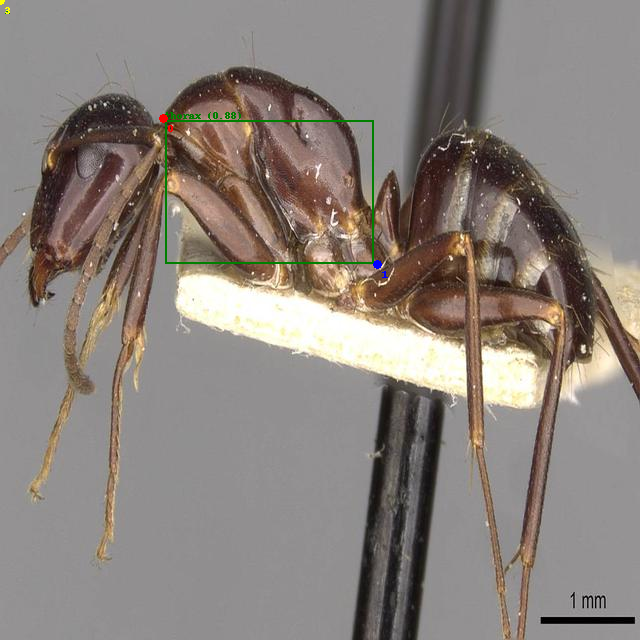

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw
from IPython.display import display


def visualize_predictions(image_path, results, save_dir='./predicted'):
    # Load the image using PIL
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Get the first result
    # result = results[0]
    
    # Draw bounding boxes
    boxes = results[0].boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Get confidence and class information
        confidence = box.conf[0]
        class_id = box.cls[0]
        class_name = results[0].names[int(class_id)]
        
        # Draw rectangle
        draw.rectangle([(x1, y1), (x2, y2)], outline="green", width=2)
        
        # Add label
        label = f"{class_name} ({confidence:.2f})"
        draw.text((x1, y1 - 10), label, fill="green")
    
    # Draw keypoints if they exist
    if hasattr(results[0], 'keypoints'):
        keypoints = results[0].keypoints
        colors = ["red", "blue", "green", "yellow", "purple"]  # PIL color names
        
        # Convert keypoints to numpy if needed
        if hasattr(keypoints, 'data'):
            kpts = keypoints.data.cpu().numpy()
        else:
            kpts = keypoints.cpu().numpy()
        
        # Draw each keypoint
        for det_idx, det_kpts in enumerate(kpts):
            for idx, kpt in enumerate(det_kpts):
                x, y = int(kpt[0]), int(kpt[1])
                confidence = float(kpt[2]) if kpt.shape[0] > 2 else 1.0
                
                if confidence > 0.5:
                    color = colors[idx % len(colors)]
                    # Draw circle for keypoint
                    draw.ellipse(
                        [(x-4, y-4), (x+4, y+4)],
                        fill=color,
                        outline=color
                    )
                    # Add keypoint index
                    draw.text((x+5, y+5), str(idx), fill=color)
            
            # Draw connections between keypoints if defined
            # if hasattr(results[0], 'keypoint_links'):
            #     for link in results[0].keypoint_links:
            #         pt1 = tuple(map(int, det_kpts[link[0]][:2]))
            #         pt2 = tuple(map(int, det_kpts[link[1]][:2]))
            #         draw.line([pt1, pt2], fill="white", width=1)
            
    display(image)
# model = YOLO("runs/pose/train/weights/best.pt")
image_path = './thorax_and_scale_dataset/images/train/casent0910427_p_1.jpg'
results = model.predict(source=image_path)
visualize_predictions(image_path, results)

In [ ]:
results[0].names

{0: 'thorax', 1: 'bar'}